In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

Note: I added new features and fixed some old features, so older models might perform worse/better if running the same notebook.

In [3]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

In [4]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_AdjD,T2_AdjT,T2_Luck,T2_Strength of Schedule_AdjEM,T2_Strength of Schedule_OppO,T2_Strength of Schedule_OppD,T2_NCSOS_AdjEM,T1_seed,T2_seed,SeedDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,108.7,68.4,0.037,-12.96,94.4,107.4,-8.09,16,16,0
1,2003,134,1411,84,1421,92,0,1,29,67,...,113.5,68.0,0.119,-6.45,98.3,104.7,11.61,16,16,0
2,2003,136,1436,51,1112,80,0,0,20,64,...,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,16,1,15
3,2003,136,1112,80,1436,51,0,0,31,66,...,99.5,64.4,0.019,-5.14,99.3,104.4,-2.29,1,16,-15
4,2003,136,1113,84,1272,71,0,0,31,59,...,94.1,68.3,0.005,4.83,103.4,98.6,3.33,10,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,152,1403,61,1277,51,0,0,22,51,...,90.2,66.9,0.001,13.67,110.6,96.9,3.24,3,2,1
2226,2019,152,1120,62,1438,63,0,0,21,55,...,89.2,59.4,0.050,11.18,109.2,98.1,-3.24,5,1,4
2227,2019,152,1438,63,1120,62,0,0,25,51,...,95.9,67.9,0.008,12.23,110.7,98.5,2.63,1,5,-4
2228,2019,154,1438,85,1403,77,0,1,27,59,...,84.1,66.6,0.004,11.18,109.8,98.7,-5.39,1,3,-2


# Model Building

In [5]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [6]:
features_all = [
 'T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_FTMmean',
 'T1_FTAmean',
 'T1_ORmean',
 'T1_DRmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_Blkmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_FTMmean',
 'T1_opponent_FTAmean',
 'T1_opponent_ORmean',
 'T1_opponent_DRmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_opponent_PFmean',
 'T1_Ptsmean',
 'T1_opponent_Ptsmean',
 'Posmean',
 'T1_OffRtgmean',
 'T1_opponent_OffRtgmean',
 'T1_DefRtgmean',
 'T1_opponent_DefRtgmean',
 'T1_NetRtgmean',
 'T1_opponent_NetRtgmean',
 'T1_AstRmean',
 'T1_opponent_AstRmean',
 'T1_TORmean',
 'T1_opponent_TORmean',
 'T1_TSPmean',
 'T1_opponent_TSPmean',
 'T1_eFGPmean',
 'T1_opponent_eFGPmean',
 'T1_FTARmean',
 'T1_opponent_FTARmean',
 'T1_ORPmean',
 'T1_opponent_ORPmean',
 'T1_DRPmean',
 'T1_opponent_DRPmean',
 'T1_RPmean',
 'T1_opponent_RPmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_FTMmean',
 'T2_FTAmean',
 'T2_ORmean',
 'T2_DRmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_Blkmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_FTMmean',
 'T2_opponent_FTAmean',
 'T2_opponent_ORmean',
 'T2_opponent_DRmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_opponent_PFmean',
 'T2_Ptsmean',
 'T2_opponent_Ptsmean',
 'T2_Posmean',
 'T2_OffRtgmean',
 'T2_opponent_OffRtgmean',
 'T2_DefRtgmean',
 'T2_opponent_DefRtgmean',
 'T2_NetRtgmean',
 'T2_opponent_NetRtgmean',
 'T2_AstRmean',
 'T2_opponent_AstRmean',
 'T2_TORmean',
 'T2_opponent_TORmean',
 'T2_TSPmean',
 'T2_opponent_TSPmean',
 'T2_eFGPmean',
 'T2_opponent_eFGPmean',
 'T2_FTARmean',
 'T2_opponent_FTARmean',
 'T2_ORPmean',
 'T2_opponent_ORPmean',
 'T2_DRPmean',
 'T2_opponent_DRPmean',
 'T2_RPmean',
 'T2_opponent_RPmean',
 'T2_PointDiffmean',
 'T1_win_ratio_14d',
 'T2_win_ratio_14d',
 'T1_Rk',
 'T1_AdjEM',
 'T1_AdjO',
 'T1_AdjD',
 'T1_AdjT',
 'T1_Luck',
 'T1_Strength of Schedule_AdjEM',
 'T1_Strength of Schedule_OppO',
 'T1_Strength of Schedule_OppD',
 'T1_NCSOS_AdjEM',
 'T2_Rk',
 'T2_AdjEM',
 'T2_AdjO',
 'T2_AdjD',
 'T2_AdjT',
 'T2_Luck',
 'T2_Strength of Schedule_AdjEM',
 'T2_Strength of Schedule_OppO',
 'T2_Strength of Schedule_OppD',
 'T2_NCSOS_AdjEM',
 'T1_seed',
 'T2_seed',
 'SeedDiff'
]

features_old = [
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
       'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
       'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
       'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
       'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
       'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 
    'T1_seed', 'T2_seed',
#        'SeedDiff'
]

features2 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
   'SeedDiff'
]

In [7]:
boxscore_features = [
 'T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_FTMmean',
 'T1_FTAmean',
 'T1_ORmean',
 'T1_DRmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_Blkmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_FTMmean',
 'T1_opponent_FTAmean',
 'T1_opponent_ORmean',
 'T1_opponent_DRmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_opponent_PFmean',
 'T1_Ptsmean',
 'T1_opponent_Ptsmean',
 'Posmean',
 'T1_OffRtgmean',
 'T1_opponent_OffRtgmean',
 'T1_DefRtgmean',
 'T1_opponent_DefRtgmean',
 'T1_NetRtgmean',
 'T1_opponent_NetRtgmean',
 'T1_AstRmean',
 'T1_opponent_AstRmean',
 'T1_TORmean',
 'T1_opponent_TORmean',
 'T1_TSPmean',
 'T1_opponent_TSPmean',
 'T1_eFGPmean',
 'T1_opponent_eFGPmean',
 'T1_FTARmean',
 'T1_opponent_FTARmean',
 'T1_ORPmean',
 'T1_opponent_ORPmean',
 'T1_DRPmean',
 'T1_opponent_DRPmean',
 'T1_RPmean',
 'T1_opponent_RPmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_FTMmean',
 'T2_FTAmean',
 'T2_ORmean',
 'T2_DRmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_Blkmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_FTMmean',
 'T2_opponent_FTAmean',
 'T2_opponent_ORmean',
 'T2_opponent_DRmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_opponent_PFmean',
 'T2_Ptsmean',
 'T2_opponent_Ptsmean',
 'T2_Posmean',
 'T2_OffRtgmean',
 'T2_opponent_OffRtgmean',
 'T2_DefRtgmean',
 'T2_opponent_DefRtgmean',
 'T2_NetRtgmean',
 'T2_opponent_NetRtgmean',
 'T2_AstRmean',
 'T2_opponent_AstRmean',
 'T2_TORmean',
 'T2_opponent_TORmean',
 'T2_TSPmean',
 'T2_opponent_TSPmean',
 'T2_eFGPmean',
 'T2_opponent_eFGPmean',
 'T2_FTARmean',
 'T2_opponent_FTARmean',
 'T2_ORPmean',
 'T2_opponent_ORPmean',
 'T2_DRPmean',
 'T2_opponent_DRPmean',
 'T2_RPmean',
 'T2_opponent_RPmean',
 'T2_PointDiffmean',
 'T1_win_ratio_14d',
 'T2_win_ratio_14d',
#  'T1_seed',
#  'T2_seed',
#  'SeedDiff'
]

kenpom_features = [
#  'T1_Rk',
 'T1_AdjEM',
 'T1_AdjO',
 'T1_AdjD',
 'T1_AdjT',
 'T1_Luck',
 'T1_Strength of Schedule_AdjEM',
 'T1_Strength of Schedule_OppO',
 'T1_Strength of Schedule_OppD',
 'T1_NCSOS_AdjEM',
#  'T2_Rk',
 'T2_AdjEM',
 'T2_AdjO',
 'T2_AdjD',
 'T2_AdjT',
 'T2_Luck',
 'T2_Strength of Schedule_AdjEM',
 'T2_Strength of Schedule_OppO',
 'T2_Strength of Schedule_OppD',
 'T2_NCSOS_AdjEM',
]

In [8]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

# Model Building Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import linear_model
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def reg_cv_train(
    features, 
                estimator, 
                 mode='reg', 
                 plot=False, 
                 verbose=False,
                 test_df=None,
                 tourney_data=tourney_data
                ):
    preds_test=None
    # get full dataset:
    df = tourney_data.dropna(how='any').reset_index().copy()

    # split X and y:
    X = df[features]
    y = np.where(df['T1_PointDiff'] > 0, 1, 0)

    # use leave-one-group-out:
    logo = LeaveOneGroupOut()
    groups = df['Season']

    cvs = []
    
    season_ix = list(set(groups))
    season_ix.sort()

    for i , (train_ix, val_ix) in enumerate(logo.split(X, y, groups)):
        # split data:
        X_train = X.iloc[train_ix]
        y_train = y[train_ix]
        X_val = X.iloc[val_ix]
        y_val = y[val_ix]


        # fit pipeline:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', estimator)
        ])

        pipe.fit(X_train, y_train)

        # predict values:
        if mode == "reg":
            pred = pipe.predict(X_val)
            pred = np.clip(pred, 0, 1) # because regression
            if test_df is not None:
                preds_test = pipe.predict(test_df[features])
                preds_test = np.clip(preds_test, 0, 1)
        else:
            pred = pipe.predict_proba(X_val)[:, 1]
            if test_df is not None:
                preds_test = pipe.predict_proba(test_df[features])[:, 1]
        # plot:
        if plot:
            plt.figure(figsize=(15,6))
            plt.subplot(1,2,1)
            plt.scatter(pred, df.loc[val_ix, 'PointDiff'], s=5)
            plt.subplot(1,2,2)
            sns.histplot(pred)
            plt.show()

        # loss:
        loss = log_loss(y_val, pred)
        cvs.append(loss)

        if verbose: print(f"{season_ix[i]} Loss : {loss}")
    
    plt.figure()
    plt.plot(range(min(groups), min(groups) + len(set(groups))), cvs)
    plt.xlabel("Year")
    plt.ylabel("Log Loss")

    print(f"Local CV Loss : {np.mean(cvs):.3f}  -----  {estimator.__class__.__name__}")
    return np.mean(cvs), preds_test

# Logistic Regression

2003 Loss : 0.4630641746663534
2004 Loss : 0.44849707975975106


c:\users\matan\github\kaggle-march-madness-2021\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2005 Loss : 0.34332860829593603
2006 Loss : 0.3974110133555204
2007 Loss : 0.4129735498461494
2008 Loss : 0.3380480615145452
2009 Loss : 0.37626458278464686
2010 Loss : 0.4302262199040111
2011 Loss : 0.6479250717885154
2012 Loss : 0.4556712447593269
2013 Loss : 0.3695742087288778
2014 Loss : 0.3909809634407182
2015 Loss : 0.4772647747704335
2016 Loss : 0.46316077918659715
2017 Loss : 0.38657190728907903
2018 Loss : 0.42162507010290434
2019 Loss : 0.2799110085801475
Local CV Loss : 0.418  -----  LogisticRegression
Wall time: 1.93 s


(0.41779401875138317, None)

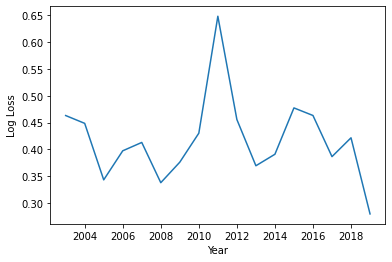

In [10]:
%%time
from sklearn.linear_model import LinearRegression, LogisticRegression

# basic model:
model = LogisticRegression(max_iter=200)

reg_cv_train(
        features=features_all, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True)

2003 Loss : 0.5870319107634772
2004 Loss : 0.6154256291664867
2005 Loss : 0.5128020424955245
2006 Loss : 0.6068651150882121
2007 Loss : 0.49889097166854685
2008 Loss : 0.4807005020853071
2009 Loss : 0.6154823952550024
2010 Loss : 0.6352110886028872
2011 Loss : 0.6535756990318132
2012 Loss : 0.6138930026923797
2013 Loss : 0.5800242542036015
2014 Loss : 0.6067960724299931
2015 Loss : 0.5724271442117443
2016 Loss : 0.5996846138516116
2017 Loss : 0.5624731347871711
2018 Loss : 0.6565135298267926
2019 Loss : 0.5349191121825976
Local CV Loss : 0.584  -----  LogisticRegression


(0.5842774246084206, None)

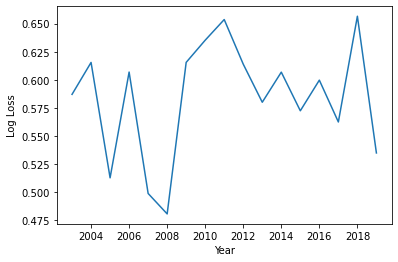

In [11]:
# basic model:
model = LogisticRegression(max_iter=200)

reg_cv_train(
        features=boxscore_features, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True)

2003 Loss : 0.41576511264510485
2004 Loss : 0.4516529228989616
2005 Loss : 0.40655650123182907
2006 Loss : 0.47459357820923015
2007 Loss : 0.3596051963856328
2008 Loss : 0.4252213808784183
2009 Loss : 0.4046541905093657
2010 Loss : 0.46590820935947064
2011 Loss : 0.6042696382902006
2012 Loss : 0.49529605330239873
2013 Loss : 0.5009354598177387
2014 Loss : 0.48023637634445354
2015 Loss : 0.4636191686287932
2016 Loss : 0.5025340899548981
2017 Loss : 0.4102838081351097
2018 Loss : 0.5139386855330439
2019 Loss : 0.39376844241923725
Local CV Loss : 0.457  -----  LogisticRegression


(0.45699051850258154, None)

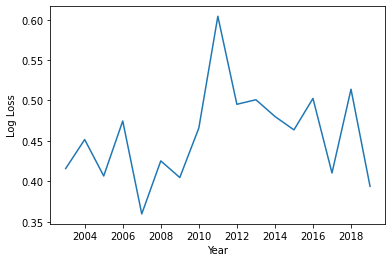

In [12]:
# basic model:
model = LogisticRegression(max_iter=200)

reg_cv_train(
        features=kenpom_features, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True)

# Test Set

In [13]:
from src.features import build_features

test_data = pd.read_csv("../data/external/MSampleSubmissionStage2.csv")
test_data[['Season', 'T1_TeamID', 'T2_TeamID']] = test_data['ID'].str.split("_",expand=True)
for c in ['Season', 'T1_TeamID', 'T2_TeamID']:
    test_data[c] = test_data[c].astype(int)
    
test_data = build_features.build_test_data(test_data)

Local CV Loss : 0.418  -----  LogisticRegression
Local CV Loss : 0.584  -----  LogisticRegression
Local CV Loss : 0.457  -----  LogisticRegression


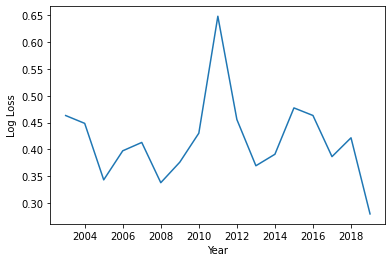

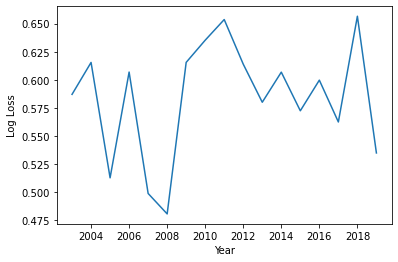

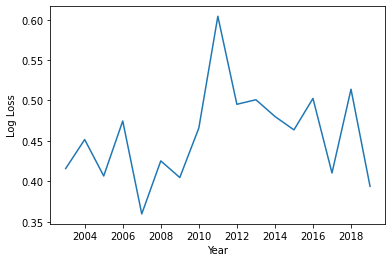

In [14]:
cv_scores = []
train_preds_all = []
model = linear_model.LogisticRegression(max_iter=300)

train_set = tourney_data.dropna(how='any').reset_index(drop=True).copy()

for f_set in [features_all, boxscore_features, kenpom_features]:
    scores, train_preds = reg_cv_train(
            features=f_set, 
            estimator=model,
            mode='cls', 
            plot=False, 
            verbose=False,
            test_df=train_set
    )
    cv_scores.append(scores)
    train_preds_all.append(train_preds)

2003 Loss : 0.6559333930106233
2004 Loss : 0.666525862527203
2005 Loss : 0.6249244562393552
2006 Loss : 0.6365970519887543
2007 Loss : 0.5874235956449255
2008 Loss : 0.5845405626521313
2009 Loss : 0.6356191612567132
2010 Loss : 0.6533927039278392
2011 Loss : 0.671106645183274
2012 Loss : 0.6375530459385358
2013 Loss : 0.6415290825285571
2014 Loss : 0.6324397118914366
2015 Loss : 0.6181173864498694
2016 Loss : 0.6196927468036099
2017 Loss : 0.6559298105615045
2018 Loss : 0.6516370320612306
2019 Loss : 0.6044362212974004
Local CV Loss : 0.634  -----  LogisticRegression
Wall time: 2.1 s


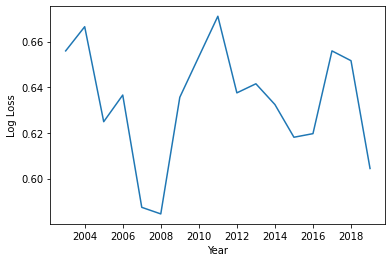

In [15]:
%%time
from sklearn.feature_selection import RFE

model = LinearRegression()

# get full dataset:
df = tourney_data.dropna(how='any').reset_index(drop=True).copy()

# split X and y:
features_RFE = [f for f in features_all if f not in ['T1_seed', 'T2_seed']]
X = df[features_RFE]
y = np.where(df['T1_PointDiff'] > 0, 1, 0)

selector = RFE(model, step=1, n_features_to_select=8)
selector.fit(X, y)

from itertools import compress
features_RFE = list(compress(features_RFE, selector.support_))

model = LogisticRegression(max_iter=300)

rfe_scores, rfe_train_preds = reg_cv_train(
        features=features_RFE, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True,
        test_df=df
)
train_preds_all.append(rfe_train_preds)

In [16]:
train_preds = pd.DataFrame(train_preds_all, index=['All', 'Boxscore', 'KenPom', 'RFE']).T
train_preds = train_preds.reset_index(drop=True)

In [17]:
train_preds['target'] = y
train_preds

,All,Boxscore,KenPom,RFE,target
0,0.922818,0.284001,0.734015,0.079168,1
1,0.077164,0.716017,0.265986,0.440574,0
2,0.001971,0.187645,0.009083,0.390533,0
3,0.998028,0.812357,0.990917,0.643402,1
4,0.654667,0.560878,0.465342,0.401820,1
...,...,...,...,...,...
2221,0.645681,0.748919,0.457897,0.645365,1
2222,0.163505,0.262971,0.135899,0.374033,0
2223,0.836522,0.737019,0.864101,0.824620,1
2224,0.727998,0.583037,0.725094,0.766123,1


In [18]:
# ensemble:
model_ensemble = linear_model.LogisticRegression()

X = train_preds[['Boxscore', 'KenPom', 'RFE']]
y = train_preds['target']

model.fit(X, y)

ensemble_preds = model.predict_proba(X)[:, 1]

log_loss(y, ensemble_preds)

0.45550554071784344

# Final Model

In [115]:
test_data

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,...,T2_AdjD,T2_AdjT,T2_Luck,T2_Strength of Schedule_AdjEM,T2_Strength of Schedule_OppO,T2_Strength of Schedule_OppD,T2_NCSOS_AdjEM,T1_seed,T2_seed,SeedDiff
0,2021_1101_1104,0.5,2021,1101,1104,27.173913,59.043478,8.130435,21.565217,13.826087,...,86.0,73.9,0.031,14.20,109.7,95.5,8.88,14,2,12
1,2021_1101_1111,0.5,2021,1101,1111,27.173913,59.043478,8.130435,21.565217,13.826087,...,103.0,65.7,0.060,-2.97,100.1,103.1,5.72,14,16,-2
2,2021_1101_1116,0.5,2021,1101,1116,27.173913,59.043478,8.130435,21.565217,13.826087,...,89.2,73.1,0.056,11.19,108.2,97.0,-5.28,14,3,11
3,2021_1101_1124,0.5,2021,1101,1124,27.173913,59.043478,8.130435,21.565217,13.826087,...,93.0,68.4,0.050,9.57,106.4,96.9,-4.18,14,1,13
4,2021_1101_1140,0.5,2021,1101,1140,27.173913,59.043478,8.130435,21.565217,13.826087,...,91.4,68.0,0.045,10.28,107.8,97.5,8.69,14,6,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452,1457,26.333333,61.481481,7.259259,20.333333,17.370370,...,95.4,73.6,0.032,-6.45,98.8,105.3,3.95,3,12,-9
2274,2021_1452_1458,0.5,2021,1452,1458,26.333333,61.481481,7.259259,20.333333,17.370370,...,89.1,64.9,-0.049,18.06,111.7,93.7,1.22,3,9,-6
2275,2021_1455_1457,0.5,2021,1455,1457,23.894737,59.000000,8.368421,24.263158,15.736842,...,95.4,73.6,0.032,-6.45,98.8,105.3,3.95,11,12,-1
2276,2021_1455_1458,0.5,2021,1455,1458,23.894737,59.000000,8.368421,24.263158,15.736842,...,89.1,64.9,-0.049,18.06,111.7,93.7,1.22,11,9,2


In [54]:
# get full dataset:
train_set = tourney_data.dropna(how='any').reset_index(drop=True).copy()
scaler = StandardScaler()

y = np.where(train_set['T1_PointDiff'] > 0, 1, 0)

scaler.fit(train_set)
train_set_scaled = pd.DataFrame(scaler.fit_transform(train_set[features_all]), columns=features_all)

# boxscore model:
bs_model = LogisticRegression(max_iter=300)
bs_model.fit(train_set_scaled[boxscore_features], y)
bs_preds = bs_model.predict_proba(train_set_scaled[boxscore_features])[:, 1]

# kenpom model:
kp_model = LogisticRegression(max_iter=300)
kp_model.fit(train_set_scaled[kenpom_features], y)
kp_preds = kp_model.predict_proba(train_set_scaled[kenpom_features])[:, 1]


# RFE model:
rfe_model = LogisticRegression(max_iter=300)
rfe_model.fit(train_set_scaled[features_RFE], y)
rfe_preds = rfe_model.predict_proba(train_set_scaled[features_RFE])[:, 1]

# all features model
all_model = LogisticRegression(max_iter=300)
all_model.fit(train_set_scaled[features_all], y)

# preds:
preds = pd.DataFrame([
    bs_model.predict_proba(train_set_scaled[boxscore_features])[:, 1],
    kp_model.predict_proba(train_set_scaled[kenpom_features])[:, 1],
    rfe_model.predict_proba(train_set_scaled[features_RFE])[:, 1]
])

# ensemble model:
ens_model = LogisticRegression(max_iter=300)
ens_model.fit(preds.T, y)
ens_preds = ens_model.predict_proba(preds.T)[:, 1]

# final log_loss:
print(f"Final Log Loss : {log_loss(y, ens_model.predict_proba(preds.T)[:, 1])}")

test_data_scaled = pd.DataFrame(scaler.transform(test_data[features_all]),  columns=features_all)
final_preds_1 = pd.DataFrame([
    bs_model.predict_proba(test_data_scaled[boxscore_features])[:, 1],
    kp_model.predict_proba(test_data_scaled[kenpom_features])[:, 1],
    rfe_model.predict_proba(test_data_scaled[features_RFE])[:, 1]
], index=['boxscore', 'kenpom', 'rfe'])
final_preds_1 = final_preds_1.T
final_preds_2 = ens_model.predict_proba(final_preds_1)[:, 1]

all_model_final_preds = all_model.predict_proba(test_data_scaled[features_all])[:, 1]

Final Log Loss : 0.4552497098046966


In [58]:
for c in final_preds_1.columns:
    test_data[f"preds_{c}"] = final_preds_1[c]
    sub = test_data[['ID', f"preds_{c}"]]
    sub.columns = ['ID', 'Pred']
    sub.to_csv(f'../models/{c}.csv', index=False)
    
test_data[f"all_feats_preds"] = all_model_final_preds
sub_ = test_data[['ID', 'all_feats_preds']]
sub_.columns = ['ID', 'Pred']
sub_.to_csv("../models/all_feats.csv", index=False)

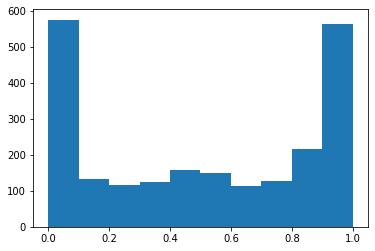

In [57]:
plt.hist(all_model_final_preds);

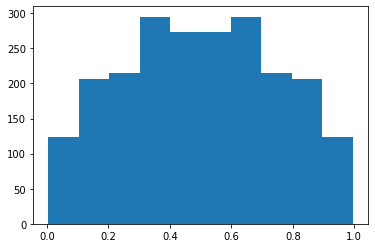

In [35]:
plt.hist(bs_preds);

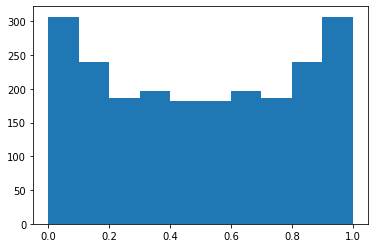

In [36]:
plt.hist(kp_preds);

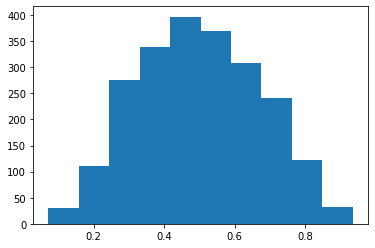

In [37]:
plt.hist(rfe_preds);

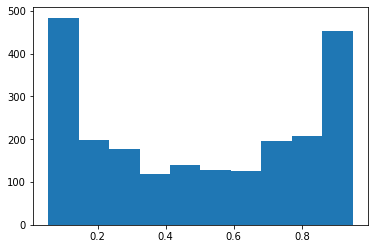

In [38]:
plt.hist(ens_preds);

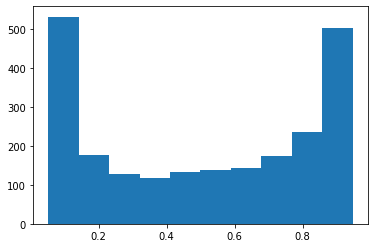

In [39]:
plt.hist(final_preds);

In [40]:
train_set['ens_preds'] = ens_preds

2003 Loss : 0.45822008741675757
2004 Loss : 0.45421849475634474
2005 Loss : 0.45805115940971464
2006 Loss : 0.4535731745642965
2007 Loss : 0.46191380804371013
2008 Loss : 0.4570451091482002
2009 Loss : 0.45740924568356206
2010 Loss : 0.4551766004410845
2011 Loss : 0.4456042073363778
2012 Loss : 0.45401894241506574
2013 Loss : 0.4534771267977293
2014 Loss : 0.45299300815583915
2015 Loss : 0.45530131376740685
2016 Loss : 0.4532671577165647
2017 Loss : 0.45741412327712727
2018 Loss : 0.4526047533783779
2019 Loss : 0.45891718015081123
Local CV Loss : 0.455  ---- Ensemble


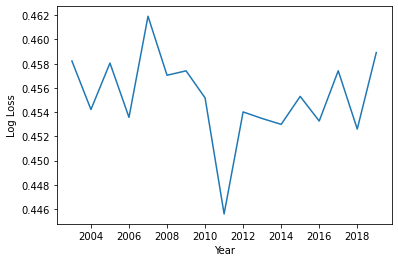

In [42]:
df = train_set.copy()

# split X and y:
X = df.copy()
y = np.where(df['T1_PointDiff'] > 0, 1, 0)

# use leave-one-group-out:
logo = LeaveOneGroupOut()
groups = df['Season']

cvs = []

season_ix = list(set(groups))
season_ix.sort()

for i , (train_ix, val_ix) in enumerate(logo.split(X, y, groups)):
    pred = df.loc[train_ix, 'ens_preds']
    y_val = y[train_ix]

    # loss:
    loss = log_loss(y_val, pred)
    cvs.append(loss)

    print(f"{season_ix[i]} Loss : {loss}")

plt.figure()
plt.plot(range(min(groups), min(groups) + len(set(groups))), cvs)
plt.xlabel("Year")
plt.ylabel("Log Loss")

print(f"Local CV Loss : {np.mean(cvs):.3f}  ---- Ensemble")


In [43]:
# save predictions
test_data['Pred'] = final_preds

submission = test_data[['ID', 'Pred']]
submission.to_csv('../models/logistic_ensemble_2.csv', index=False)